# Challenge A by Salvatore Cavallaro (University of Catania)

Let's import the libraries which will be used to solve the Challenge Task.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import face_utils
import dlib

The dataset and the related information are stored into a personal folder in Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here we define some useful data:

In [ ]:
training_dir = "/content/drive/MyDrive/Machine Learning Competition/challengeA_data/challengeA_data/images_train"
test_dir = "/content/drive/MyDrive/Machine Learning Competition/challengeA_data/challengeA_data/images_test"
training_csv_dir = "/content/drive/MyDrive/Machine Learning Competition/challengeA_data/challengeA_data/challengeA_train.csv"
test_csv_dir = "/content/drive/MyDrive/Machine Learning Competition/challengeA_data/challengeA_data/challengeA_test.csv"
img_h, img_w, img_c = 48, 48, 3

We define also two functions to plot diagrams related to *loss* and *accuracy* of trained models:

In [ ]:
def plotAccuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [ ]:
def plotLoss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

#Explanatory analysis of the dataset

Before beginning the explanatory analysis we read the images and labels of our datasets.

### Reading of the dataset from the directory to a Numpy file

Here we define a function to read the dataset from the directory into a Tensor: it is a time consuming operation!

In [ ]:
def readToTensor(directory):    
    X_content = tf.zeros([0, img_h, img_w, img_c], dtype='uint8')    
    for img in tqdm(os.listdir(directory)): 
        img_content = cv2.imread(os.path.join(directory, img)) 
        tmp_content = tf.convert_to_tensor(img_content) 
        X_content = tf.concat([X_content, [tmp_content]], 0)
    
    return X_content
   

Then we actually fill our tensors with training and test images:

In [ ]:
X_train = readToTensor(training_dir)
X_test_label = readToTensor(test_dir)

The datasets are then saved as a binary file into the current directory

In [ ]:
X_train_save = X_train.numpy()
np.save("datasetTrain", X_train_save)

X_test_save = X_test.numpy()
np.save("datasetTest", X_test_save)

### Reading of the dataset from the binary files

A faster way to charge our images dataset is using the binary files .npy previously saved

In [ ]:
X_train = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTrain.npy")
X_test_label = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTest.npy")

### Reading of the *labels* from the $.csv$ file

Now it's time to load information from .csv file provided for the challenge containing labeling information.

In [ ]:
def readCSVLabels(directory):
    df = pd.read_csv(directory, sep=',',header=0)  #.csv content is put into a dataframe to be processed correctly as a table
    df_sorted = df.sort_values("image_id")    #read content is order to use an ascending approach according to the label id (same ordering of TRAINING directory -> X_train and labels match)   
    df_sorted = df_sorted["emotion"].values  #'emotion' column is what we are interested in -> we just keep it as a Numpy array
    return df_sorted

In [ ]:
Y_train = readCSVLabels(training_csv_dir)

##Dataset statistics

Let's try to discover how many images contain the *training dataset* and the *test dataset*.

In [ ]:
print("There are "+str(X_train.shape[0])+" images into the training dataset!")

There are 30503 images into the training dataset!


In [ ]:
print("There are "+str(X_test_label.shape[0])+" images into the test dataset to be labeled by our model!")

There are 4038 images into the test dataset to be labeled by our model!


Now we want to know something about the distribution of the 7 classes among the elements of the *training dataset*.

In [ ]:
classes = []
df = pd.read_csv(training_csv_dir, sep=',',header=0)
for i in range(7):
  classes.append(df[df.emotion == i].shape[0])
  print("Class "+str(i)+": "+str(classes[i]))

Class 0: 4198
Class 1: 466
Class 2: 4320
Class 3: 7682
Class 4: 5177
Class 5: 3401
Class 6: 5259


We can see that the unbalancing is mainly focused on class 1 (Disgust), so it will be necessary to consider if this aspect could lead to bad performances of our models in the following steps.

##Image properties

Firstly, let's try to visualize an example image from our dataset (and the label):

The label for this image is: 6


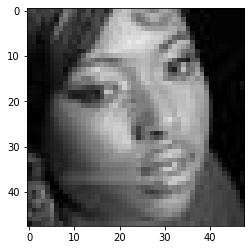

In [ ]:
plt.imshow(X_train[0])
print("The label for this image is: "+str(Y_train[0]))
plt.show()  

As we can see above the image is represented as a grayscale picture. Let's try to see the shape of the related Numpy array item from the dataset.

In [ ]:
print("The shape is: "+str(X_train[0].shape))

The shape is: (48, 48, 3)


Therefore, the image is $48x48$ pixels with 3 channels. This information will be kept in consideration to define the architecture of the Models in the following steps.

##Patterns visualization

First, we split our original dataset into 7 different subsets through a Dictionary, one for each class.

In [ ]:
dataset = {
    "class_0" : X_train[Y_train==0],
    "class_1" : X_train[Y_train==1],
    "class_2" : X_train[Y_train==2],
    "class_3" : X_train[Y_train==3],
    "class_4" : X_train[Y_train==4],
    "class_5" : X_train[Y_train==5],
    "class_6" : X_train[Y_train==6]
}

A first intresting information we could get from our dataset is **Average Image**. We will see how the different emotions are highly influenced by face treats (mouth, eyes, eyebrows, ...)

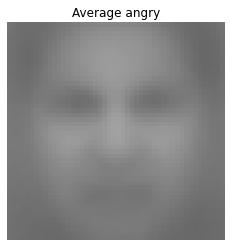

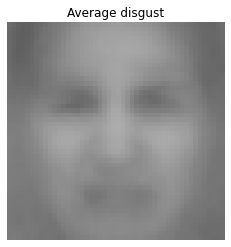

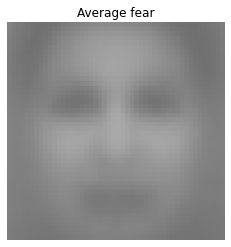

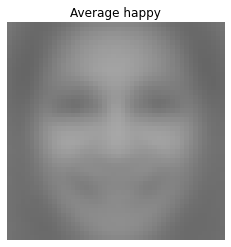

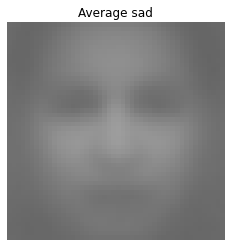

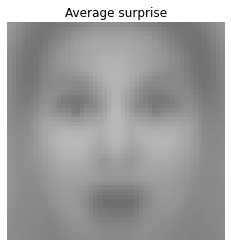

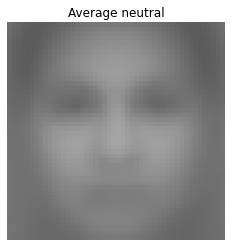

In [ ]:
def mean(datasetClass, title, size = (img_h, img_w, img_c)):
    mean_img = np.mean(datasetClass, axis = 0)
    plt.imshow(mean_img.astype(np.uint8))
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

angry_mean = mean(dataset["class_0"], 'angry')
disgust_mean = mean(dataset["class_1"], 'disgust')
fear_mean = mean(dataset["class_2"], 'fear')
happy_mean = mean(dataset["class_3"], 'happy')
sad_mean = mean(dataset["class_4"], 'sad')
surprise_mean = mean(dataset["class_5"], 'surprise')
neutral_mean = mean(dataset["class_6"], 'neutral')

Another information could be the **Contrast between images**. We might consider all the possible combination of classes, but we just show some of them to illustrate this method. We will observe that opposite sentiments shows high difference, while similar sentiments (e.g. negative) show low difference.

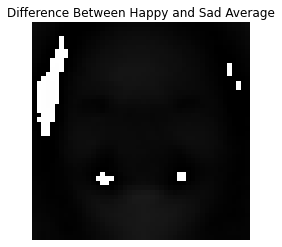

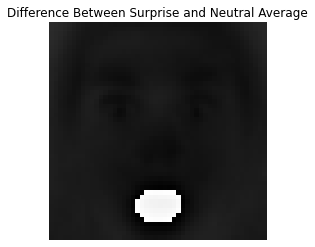

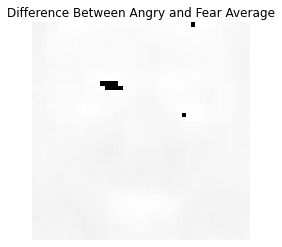

In [ ]:
contrast_mean = happy_mean - sad_mean
plt.imshow(contrast_mean.astype(np.uint8))
plt.title(f'Difference Between Happy and Sad Average')
plt.axis('off')
plt.show()

contrast_mean = surprise_mean - neutral_mean
plt.imshow(contrast_mean.astype(np.uint8))
plt.title(f'Difference Between Surprise and Neutral Average')
plt.axis('off')
plt.show()

contrast_mean = angry_mean - fear_mean
plt.imshow(contrast_mean.astype(np.uint8))
plt.title(f'Difference Between Angry and Fear Average')
plt.axis('off')
plt.show()

One more analysis can be done on **Variability** analyzing *Standard Deviation*. In particular, we will see how much variability is present for each class through lighter areas.

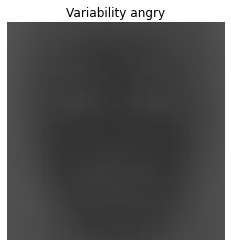

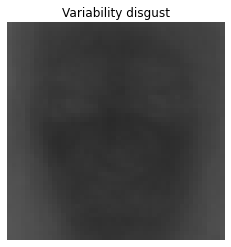

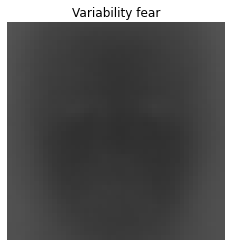

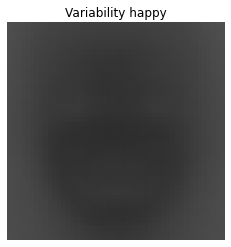

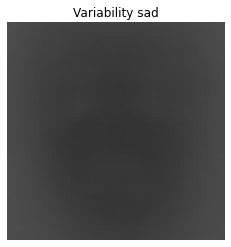

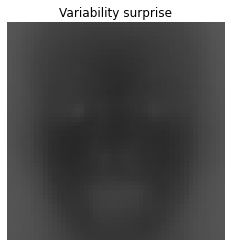

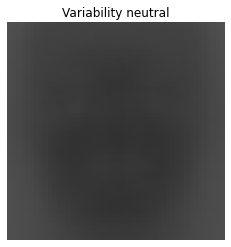

In [ ]:
def std(datasetClass, title, size = (img_h, img_w, img_c)):
    std_img = np.std(datasetClass, axis = 0)
    plt.imshow(std_img.astype(np.uint8))
    plt.title(f'Variability {title}')
    plt.axis('off')
    plt.show()
    return std_img

angry_mean = std(dataset["class_0"], 'angry')
disgust_mean = std(dataset["class_1"], 'disgust')
fear_mean = std(dataset["class_2"], 'fear')
happy_mean = std(dataset["class_3"], 'happy')
sad_mean = std(dataset["class_4"], 'sad')
surprise_mean = std(dataset["class_5"], 'surprise')
neutral_mean = std(dataset["class_6"], 'neutral')

A last step of the exploratory Data Analysis is the usage of **Principal Component Analysis** to visualize the components that are more relevant for each class in terms of variability.

Number of PC:  14


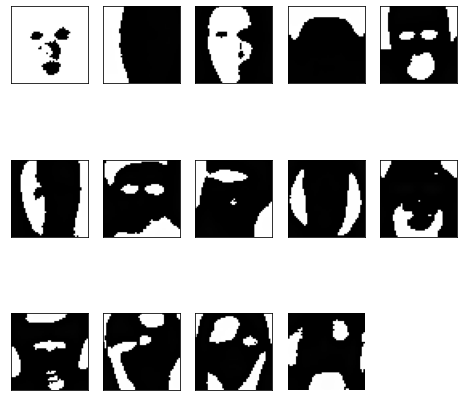

Number of PC:  10


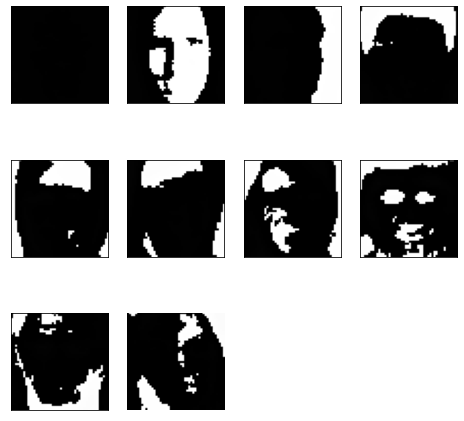

Number of PC:  15


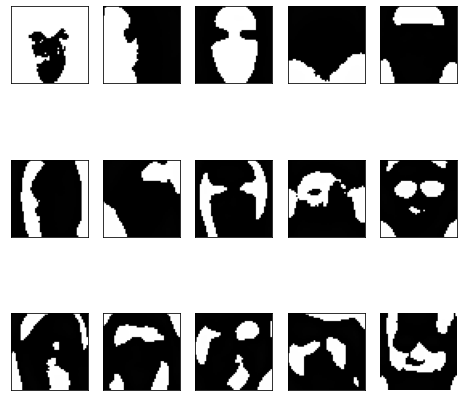

Number of PC:  13


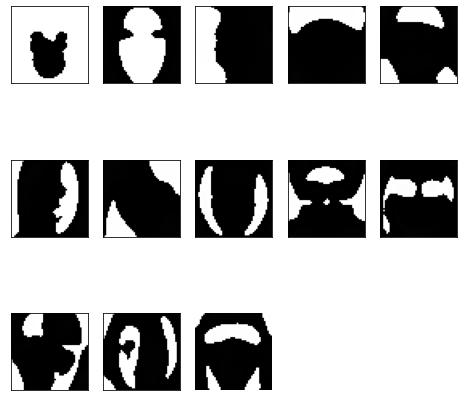

Number of PC:  14


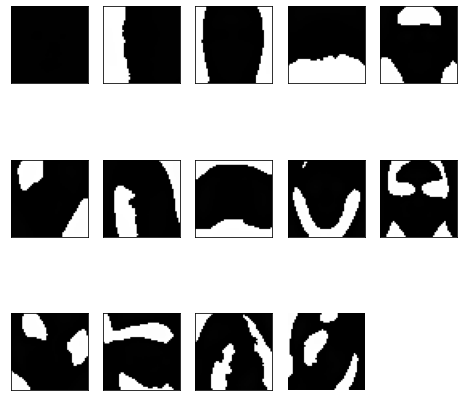

Number of PC:  14


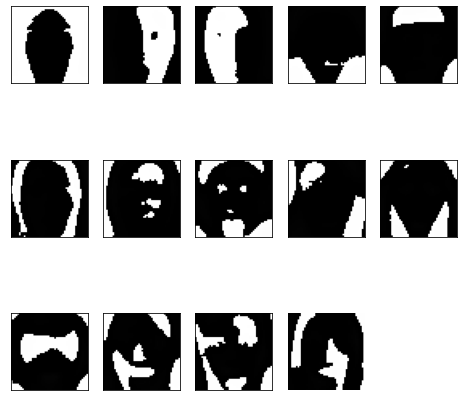

Number of PC:  12


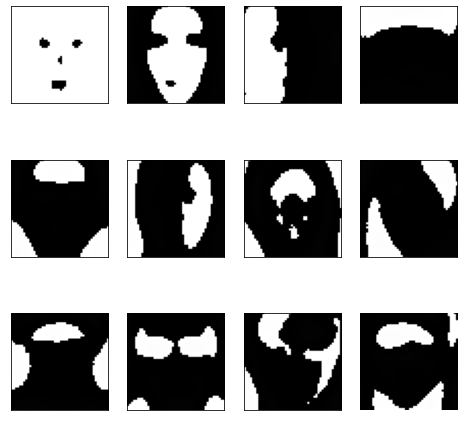

In [ ]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(datasetClass, title, n_comp = 0.7, size = (img_h, img_w, img_c)):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(np.reshape(datasetClass, (-1, img_h*img_w*img_c)))
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (img_h, img_w, img_c)):
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow((pca.components_[i].reshape(size)*110).astype(np.uint8), 
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()
    
plot_pca(eigenimages(dataset["class_0"], 'angry'))
plot_pca(eigenimages(dataset["class_1"], 'disgust'))
plot_pca(eigenimages(dataset["class_2"], 'fear'))
plot_pca(eigenimages(dataset["class_3"], 'happy'))
plot_pca(eigenimages(dataset["class_4"], 'sad'))
plot_pca(eigenimages(dataset["class_5"], 'surprise'))
plot_pca(eigenimages(dataset["class_6"], 'neutral'))


# Models 

###First model: Support Vector Machine

The first model proposed to solve our challenge is a *Support Vector Machine* trained on our dataset to recognize one of the 7 different emotions given a specific image. We first import all the necessary libraries, that are different than the ones used for the remaining four NN Models. In particular, the model is implemented using *scikit-learn*.

In [ ]:
import matplotlib as mpl
from skimage.feature import hog
from skimage.color import rgb2grey
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC

Here we define a function *create_features* which takes the 3-channel image from our dataset, processes it in order to get a flatten version and the *Histogram of oriented gradients*, then combines them.

In [ ]:
def create_features(img):
    features = img.flatten()
    grey_image = rgb2grey(img)
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    flat_features = np.hstack(features)
    return flat_features

Then, another function is defined to iterate our dataset and create an array of processed images using the function defined above.

In [ ]:
def create_feature_matrix(X_train):
    features_list = []    
    for img in tqdm(X_train):
        image_features = create_features(img)
        features_list.append(image_features)        
    feature_matrix = np.array(features_list)
    return feature_matrix

Here we actually create our Numpy array from the given dataset.

In [ ]:
feature_matrix = create_feature_matrix(X_train)

100%|██████████| 30503/30503 [09:40<00:00, 52.55it/s]


Next the dataset is standardized and processed using Principal Component Analysis in order to reduce the number of features, choosing the most releavant.

In [ ]:
ss = StandardScaler()
X_train_stand = ss.fit_transform(feature_matrix)
pca = PCA(n_components=500)
X_train_pca = ss.fit_transform(X_train_stand)

Then the dataset is split into *train* and *test*.

In [ ]:
X = pd.DataFrame(X_train_pca)
y = pd.Series(Y_train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1234123)

Now it's time to train our SVM using our dataset.

In [ ]:
model1 = LinearSVC()
model1.fit(X_train, y_train)

Finally we check the *test* accuracy.

In [ ]:
y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.2777838487596984


##Neural networks approach

Let's define some parameters useful for our NN models.

In [ ]:
EPOCHS = 50
BATCH_SIZE = 64
VERBOSE = 1
NB_CLASSES = 7
N_HIDDEN = 512
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

### Second model: Multilayer Perceptron Neural Network

A second model to execute our task of image classification is a MultiLayer Perceptron Neural Network. Let's define some functions to process our data in order to be suitable for feeding our NN.

In [ ]:
def preProcessMLP(X_train, Y_train):
  X_tensor = tf.convert_to_tensor(X_train, dtype=tf.uint8) 
  items_size = X_tensor.shape[0]
  test_size = round(items_size * TEST_SPLIT)
  train_size = items_size - test_size
  X_tensor_test = X_tensor[train_size:train_size+test_size]
  X_tensor_train = X_tensor[:train_size]
  Y_tensor_test = Y_train[train_size:train_size+test_size]
  Y_tensor_train = Y_train[:train_size]
  X_tensor_train = tf.reshape(X_tensor_train, [train_size, -1])
  X_tensor_test = tf.reshape(X_tensor_test, [test_size, -1])

  return X_tensor_train, X_tensor_test, Y_tensor_train, Y_tensor_test


Now it's time to execute the preprocessing:

In [ ]:
X_train, X_test, Y_train, Y_test = preProcessMLP(X_train, Y_train)

And also normalizing the two datasets:

In [ ]:
X_train /= 255
X_test /= 255

An useful tool to elaborate the dataset is One hot encoding:

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = keras.utils.to_categorical(Y_test, NB_CLASSES)

Now let's define the model!

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(keras.layers.Dense(N_HIDDEN*4, input_shape=(X_train.shape[1], ), activation='relu'))
model2.add(keras.layers.Dense(N_HIDDEN*2, activation='relu'))
model2.add(keras.layers.Dense(N_HIDDEN, activation='relu'))
model2.add(keras.layers.Dense(NB_CLASSES, activation='softmax'))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              14157824  
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 3591      
Total params: 16,784,391
Trainable params: 16,784,391
Non-trainable params: 0
_________________________________________________________________


Here we define the optimizer and also some tools to manage overfitting:

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1, factor = 0.50, min_lr = 1e-10)
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)

Here we train the model defined above, splitting the initial training dataset into *training* and *validation*:

In [ ]:
history = model2.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT, callbacks=[lrd,es])

Epoch 1/50
387/387 [==============================] - 3s 7ms/step - loss: 2.1647 - accuracy: 0.2506 - val_loss: 1.8088 - val_accuracy: 0.2160
Epoch 2/50
387/387 [==============================] - 2s 6ms/step - loss: 1.7198 - accuracy: 0.3142 - val_loss: 1.7796 - val_accuracy: 0.2680
Epoch 3/50
387/387 [==============================] - 2s 6ms/step - loss: 1.6716 - accuracy: 0.3374 - val_loss: 1.7707 - val_accuracy: 0.2775
Epoch 4/50
387/387 [==============================] - 2s 6ms/step - loss: 1.6587 - accuracy: 0.3443 - val_loss: 1.6603 - val_accuracy: 0.3481
Epoch 5/50
387/387 [==============================] - 3s 6ms/step - loss: 1.6344 - accuracy: 0.3572 - val_loss: 1.6068 - val_accuracy: 0.3744
Epoch 6/50
387/387 [==============================] - 3s 7ms/step - loss: 1.6244 - accuracy: 0.3649 - val_loss: 1.6419 - val_accuracy: 0.3711
Epoch 7/50
387/387 [==============================] - 2s 6ms/step - loss: 1.6185 - accuracy: 0.3637 - val_loss: 1.6247 - val_accuracy: 0.3693
Epoch 

Here we plot the information about *loss* and *accuracy* of our trained model:

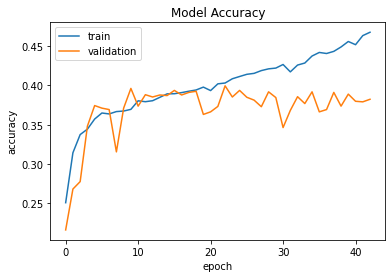

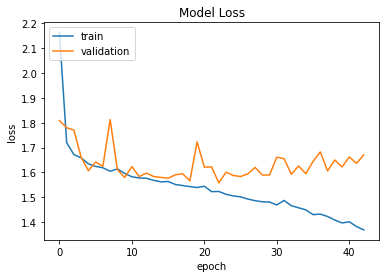

In [ ]:
plotAccuracy(history)
plotLoss(history)

Finally we print performances on *test set*:


In [ ]:
test_loss, test_acc = model2.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

96/96 [==============================] - 0s 3ms/step - loss: 1.6322 - accuracy: 0.3872
Test accuracy: 0.3872131109237671


### Third Model: a first version of a Convolutional Neural Network

First, we read again our dataset from binary files

In [ ]:
X_train = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTrain.npy")
X_test_label = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTest.npy")
Y_train = readCSVLabels(training_csv_dir)

Here we define a function to Process the read train dataset to get a correct split:

In [ ]:
def preProcessCNN(X_train, Y_train):
  items_size = X_train.shape[0]
  test_size = round(items_size * TEST_SPLIT)
  train_size = items_size - test_size
  X_test = X_train[train_size:train_size+test_size]
  X_train = X_train[:train_size]
  Y_test = Y_train[train_size:train_size+test_size]
  Y_train = Y_train[:train_size]
  return X_train, X_test, Y_train, Y_test

Then we actually read the content into the variables

In [ ]:
X_train, X_test, Y_train, Y_test = preProcessCNN(X_train, Y_train)

Labels are managed using One hot encoding

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = keras.utils.to_categorical(Y_test, NB_CLASSES)

Here we define an *ImageDataGenerator* to do an augmentation of our dataset through a series if transforms. The operation is executed on *train*, *validation* and *test* datasets.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT, rotation_range=5, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT)
test_datagen  = ImageDataGenerator(rescale = 1./255)

Next, we define the flow for our three datasets to charge data in batches:

In [ ]:
iterator_train = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='training')
iterator_valid = valid_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='validation')
iterator_test = test_datagen.flow(X_test, Y_test)

Here we define our model:

In [ ]:
model3 = tf.keras.models.Sequential()
model3.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_h, img_w, img_c)))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(keras.layers.Dropout(0.30))

model3.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(keras.layers.Dropout(0.30))

model3.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model3.add(keras.layers.Dropout(0.30))

model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(4096, activation='relu'))
model3.add(keras.layers.Dropout(0.50))
model3.add(keras.layers.Dense(1024, activation='relu'))
model3.add(keras.layers.Dropout(0.50))

model3.add(keras.layers.Dense(NB_CLASSES, activation='softmax'))

In [ ]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 64)        1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 21, 21, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)      

Here we define the optimizer and also some tools to manage overfitting:

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1, factor = 0.50, min_lr = 1e-10)
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model3.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

Here we train the model defined above, splitting the initial training dataset into *training* and *validation*:

In [ ]:
history = model3.fit(iterator_train, validation_data=iterator_valid, epochs=EPOCHS, verbose=VERBOSE, callbacks=[lrd,es])

Epoch 1/50
387/387 [==============================] - 32s 84ms/step - loss: 1.5104 - accuracy: 0.8751 - val_loss: 2.2449 - val_accuracy: 0.8507
Epoch 2/50
387/387 [==============================] - 33s 85ms/step - loss: 1.5085 - accuracy: 0.8750 - val_loss: 1.6134 - val_accuracy: 0.8678
Epoch 3/50
387/387 [==============================] - 32s 83ms/step - loss: 1.5046 - accuracy: 0.8754 - val_loss: 1.4130 - val_accuracy: 0.8797
Epoch 4/50
387/387 [==============================] - 31s 81ms/step - loss: 1.4913 - accuracy: 0.8759 - val_loss: 1.3372 - val_accuracy: 0.8848
Epoch 5/50
387/387 [==============================] - 32s 83ms/step - loss: 1.4924 - accuracy: 0.8760 - val_loss: 1.4279 - val_accuracy: 0.8758
Epoch 6/50
387/387 [==============================] - 32s 82ms/step - loss: 1.4880 - accuracy: 0.8760 - val_loss: 1.3757 - val_accuracy: 0.8820
Epoch 7/50
387/387 [==============================] - 31s 81ms/step - loss: 1.4795 - accuracy: 0.8762 - val_loss: 1.3388 - val_accuracy:

Here we plot the information about *loss* and *accuracy* of our trained model:

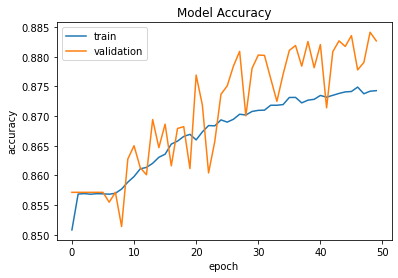

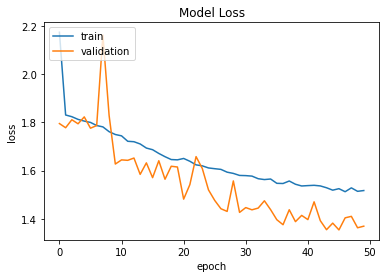

In [ ]:
plotAccuracy(history)
plotLoss(history)

Finally we print performances on *test set*:

In [ ]:
test_loss, test_acc = model3.evaluate(iterator_test)
print('Test accuracy:', test_acc)

96/96 [==============================] - 1s 6ms/step - loss: 1.3814 - accuracy: 0.8835
Test accuracy: 0.8835129141807556


### Fourth Model: A Second Version of a Convolutional Neural Network

First, we read again our dataset from binary files

In [ ]:
X_train = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTrain.npy")
X_test_label = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTest.npy")
Y_train = readCSVLabels(training_csv_dir)

Then we actually read the content into the variables

In [ ]:
X_train, X_test, Y_train, Y_test = preProcessCNN(X_train, Y_train)

Labels are managed using One hot encoding

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = keras.utils.to_categorical(Y_test, NB_CLASSES)

Here we define an *ImageDataGenerator* to do an augmentation of our dataset through a series if transforms. The operation is executed on *train*, *validation* and *test* datasets.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT, rotation_range=5, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT)
test_datagen  = ImageDataGenerator(rescale = 1./255)

Next, we define the flow for our three datasets to charge data in batches:

In [ ]:
iterator_train = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='training')
iterator_valid = valid_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='validation')
iterator_test = test_datagen.flow(X_test, Y_test)

We can create our Model as follows:

In [ ]:
model4 = tf.keras.models.Sequential()

model4.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_h, img_w, img_c)))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model4.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model4.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model4.add(keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))  
model4.add(keras.layers.BatchNormalization())
model4.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(2304, activation='relu'))
model4.add(keras.layers.Dropout(0.30))
model4.add(keras.layers.Dense(NB_CLASSES, activation='softmax'))


In [ ]:
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_16 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 24, 24, 64)       

Here we define the optimizer and also some tools to manage overfitting:

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1, factor = 0.50, min_lr = 1e-10)
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model4.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

Here we train the model defined above, splitting the initial training dataset into *training* and *validation*:

In [ ]:
history = model4.fit(iterator_train, validation_data=iterator_valid, epochs=EPOCHS, verbose=VERBOSE, callbacks=[lrd,es])

Epoch 1/50
387/387 [==============================] - 23s 56ms/step - loss: 2.2201 - accuracy: 0.8466 - val_loss: 1.9071 - val_accuracy: 0.8571
Epoch 2/50
387/387 [==============================] - 21s 55ms/step - loss: 1.7529 - accuracy: 0.8582 - val_loss: 1.7874 - val_accuracy: 0.8530
Epoch 3/50
387/387 [==============================] - 21s 55ms/step - loss: 1.6443 - accuracy: 0.8649 - val_loss: 1.5422 - val_accuracy: 0.8686
Epoch 4/50
387/387 [==============================] - 21s 54ms/step - loss: 1.5573 - accuracy: 0.8698 - val_loss: 1.4279 - val_accuracy: 0.8772
Epoch 5/50
387/387 [==============================] - 22s 56ms/step - loss: 1.4874 - accuracy: 0.8737 - val_loss: 1.5444 - val_accuracy: 0.8718
Epoch 6/50
387/387 [==============================] - 21s 55ms/step - loss: 1.4176 - accuracy: 0.8776 - val_loss: 1.3669 - val_accuracy: 0.8756
Epoch 7/50
387/387 [==============================] - 21s 55ms/step - loss: 1.3787 - accuracy: 0.8787 - val_loss: 1.3574 - val_accuracy:

Here we plot the information about *loss* and *accuracy* of our trained model:

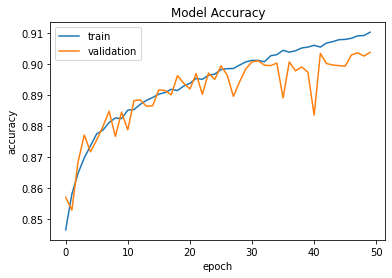

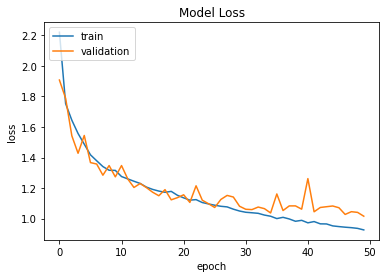

In [ ]:
plotAccuracy(history)
plotLoss(history)

Finally we print performances on *test set*:

In [ ]:
test_loss, test_acc = model4.evaluate(iterator_test)
print('Test accuracy:', test_acc)

96/96 [==============================] - 1s 6ms/step - loss: 1.0266 - accuracy: 0.9040
Test accuracy: 0.9039813280105591


### Fifth Model: Transfer Learning of a prebuilt learning model

First, we read again our dataset from binary files

In [ ]:
X_train = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTrain.npy")
X_test_label = np.load("/content/drive/MyDrive/Machine Learning Competition/datasetTest.npy")
Y_train = readCSVLabels(training_csv_dir)

Then we actually read the content into the variables

In [ ]:
X_train, X_test, Y_train, Y_test = preProcessCNN(X_train, Y_train)

Labels are managed using One hot encoding

In [ ]:
Y_train = keras.utils.to_categorical(Y_train, NB_CLASSES)
Y_test = keras.utils.to_categorical(Y_test, NB_CLASSES)

Here we define an *ImageDataGenerator* to do an augmentation of our dataset through a series if transforms. The operation is executed on *train*, *validation* and *test* datasets.

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT, rotation_range=5, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = VALIDATION_SPLIT)
test_datagen  = ImageDataGenerator(rescale = 1./255)

Next, we define the flow for our three datasets to charge data in batches:

In [ ]:
iterator_train = train_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='training')
iterator_valid = valid_datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE, subset='validation')
iterator_test = test_datagen.flow(X_test, Y_test)

We first import our pretrained Model *EfficientNetB7* trained on *imagenet*

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(48,48,3), include_top=False, weights="imagenet")

16711680/16705208 [==============================] - 0s 0us/step


First, all the layers of our pretrained Model are set as not trainable

In [ ]:
for layer in base_model.layers: 
    layer.trainable=False

Here we define our Model, adding the Fully Connected Network

In [ ]:
model5 = tf.keras.models.Sequential()

model5.add(base_model)
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(5120, activation='relu'))
model5.add(keras.layers.Dropout(0.50))
model5.add(keras.layers.Dense(NB_CLASSES, activation='softmax'))

In [ ]:
model5.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_3 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 5120)              26219520  
_________________________________________________________________
dropout_3 (Dropout)          (None, 5120)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 35847     
Total params: 30,304,938
Trainable params: 26,255,367
Non-trainable params: 4,049,571
_________________________________________________________________


Here we define the optimizer and also some tools to manage overfitting:

In [ ]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 20, verbose = 1, factor = 0.50, min_lr = 1e-10)
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]
model5.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=METRICS)

Here we train the model defined above, splitting the initial training dataset into *training* and *validation*:

In [ ]:
history = model5.fit(iterator_train, validation_data=iterator_valid, epochs=EPOCHS, verbose=VERBOSE, callbacks=[lrd,es])

Epoch 1/50
387/387 [==============================] - 30s 64ms/step - loss: 2.0787 - accuracy: 0.8520 - val_loss: 1.8096 - val_accuracy: 0.8571
Epoch 2/50
387/387 [==============================] - 23s 60ms/step - loss: 1.8275 - accuracy: 0.8571 - val_loss: 1.8004 - val_accuracy: 0.8571
Epoch 3/50
387/387 [==============================] - 23s 60ms/step - loss: 1.8268 - accuracy: 0.8571 - val_loss: 1.7973 - val_accuracy: 0.8571
Epoch 4/50
387/387 [==============================] - 23s 59ms/step - loss: 1.8250 - accuracy: 0.8571 - val_loss: 1.7992 - val_accuracy: 0.8571
Epoch 5/50
387/387 [==============================] - 23s 59ms/step - loss: 1.8216 - accuracy: 0.8571 - val_loss: 1.8034 - val_accuracy: 0.8571
Epoch 6/50
387/387 [==============================] - 24s 61ms/step - loss: 1.8199 - accuracy: 0.8571 - val_loss: 1.7967 - val_accuracy: 0.8571
Epoch 7/50
387/387 [==============================] - 24s 62ms/step - loss: 1.8182 - accuracy: 0.8571 - val_loss: 1.8011 - val_accuracy:

Here we plot the information about *loss* and *accuracy* of our trained model:

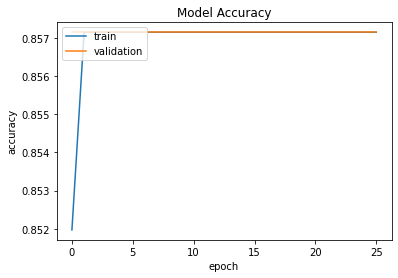

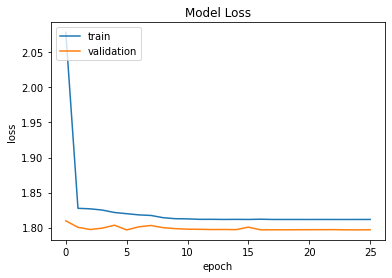

In [ ]:
plotAccuracy(history)
plotLoss(history)

Finally we print performances on *test set*:

In [ ]:
test_loss, test_acc = model5.evaluate(iterator_test)
print('Test accuracy:', test_acc)

96/96 [==============================] - 2s 17ms/step - loss: 1.8061 - accuracy: 0.8571
Test accuracy: 0.857142448425293


#Emotion assignment on *Testing set*

The evaluation of the models defined in the previous section shows that the best solution is given by **Fourth model**, a Convolutional Neural Network with an accuracy of about *90%* on testing. Now, using such a model we try to label images on *Testing set* to produce *emotion* column on the related *.csv* file.

First, let's define an ImageDataGenerator for our Testing set:

In [ ]:
test_label_datagen  = ImageDataGenerator(rescale = 1./255)

Then the flow:

In [ ]:
iterator_test_label = test_label_datagen.flow(X_test_label, shuffle=False)

Here we compute our predictions:

In [ ]:
predictions = model4.predict(iterator_test_label).argmax(axis=1)

In addition, we define a function *readCSVList* used to load our *test csv* from the directory into a numpy array and ordered by *image_id*.

In [ ]:
def readCSVList(directory):
    df = pd.read_csv(directory, sep=',',header=0)
    df_sorted = df.sort_values("image_id")
    npy = df_sorted.to_numpy()
    npy = np.delete(npy, obj=2, axis=1)
    return npy

We actually load the data from the *.csv* file on the directory.

In [ ]:
test_npy = readCSVList(test_csv_dir)

And define a function which adds predicted labels from our model creating the original structure of the *.csv* file.

In [ ]:
def addLabels(numpy_data, labels):
  labeled_npy = np.append(numpy_data, np.expand_dims(labels, axis = 1), axis=1)
  labeled_df = pd.DataFrame({'': labeled_npy[:, 0], 'image_id': labeled_npy[:, 1], 'emotion': labeled_npy[:, 2]})
  resorted_labeled_df = labeled_df.sort_values("")
  return resorted_labeled_df

Here we execute the function defined above.

In [ ]:
test_label = addLabels(test_npy, predictions)

And finally we save the labeled *.csv* Test set.

In [ ]:
test_label.to_csv('/content/drive/MyDrive/Machine Learning Competition/challengeA_data/challengeA_data/Cavallaro,Salvatore_Answers.csv', index = False)